Exploratory Data Analysis for Energy Consumption

# EnergyBlitz - Exploratory Data Analysis
## Overview
This notebook performs exploratory data analysis on the PJM energy consumption dataset and NOAA weather data. The analysis will help us understand patterns, trends, and relationships in the data that will inform our feature engineering and modeling approaches.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# Set style settings
sns.set_theme()
sns.set_palette("husl")

# Notebook-wide settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

In [3]:
def load_data():
    """
    Load both PJM and weather datasets
    """
    # Load PJM data
    pjm_path = '../data/raw/pjm_dataset/pjm_hourly_est.csv'
    df_pjm = pd.read_csv(pjm_path, parse_dates=['Datetime'])
    
    # Load weather data
    weather_path = '../data/raw/weather/noaa_data.csv'
    df_weather = pd.read_csv(weather_path, parse_dates=['timestamp'])
    
    return df_pjm, df_weather

# Load datasets
df_pjm, df_weather = load_data()

# Display basic information
print("PJM Dataset Shape:", df_pjm.shape)
print("\nPJM Dataset Columns:", df_pjm.columns.tolist())
print("\nPJM Dataset Info:")
print(df_pjm.info())

print("\nWeather Dataset Shape:", df_weather.shape)
print("\nWeather Dataset Info:")
print(df_weather.info())

PJM Dataset Shape: (178262, 13)

PJM Dataset Columns: ['Datetime', 'AEP', 'COMED', 'DAYTON', 'DEOK', 'DOM', 'DUQ', 'EKPC', 'FE', 'NI', 'PJME', 'PJMW', 'PJM_Load']

PJM Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178262 entries, 0 to 178261
Data columns (total 13 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   Datetime  178262 non-null  datetime64[ns]
 1   AEP       121273 non-null  float64       
 2   COMED     66497 non-null   float64       
 3   DAYTON    121275 non-null  float64       
 4   DEOK      57739 non-null   float64       
 5   DOM       116189 non-null  float64       
 6   DUQ       119068 non-null  float64       
 7   EKPC      45334 non-null   float64       
 8   FE        62874 non-null   float64       
 9   NI        58450 non-null   float64       
 10  PJME      145366 non-null  float64       
 11  PJMW      143206 non-null  float64       
 12  PJM_Load  32896 non-null   float64       
dt

PJM Data Time Range:
Start: 1998-04-01 01:00:00
End: 2018-08-03 00:00:00
Total Hours: 178262

Missing Data Percentages:
AEP: 31.97%
COMED: 62.7%
DAYTON: 31.97%
DEOK: 67.61%
DOM: 34.82%
DUQ: 33.21%
EKPC: 74.57%
FE: 64.73%
NI: 67.21%
PJME: 18.45%
PJMW: 19.67%
PJM_Load: 81.55%


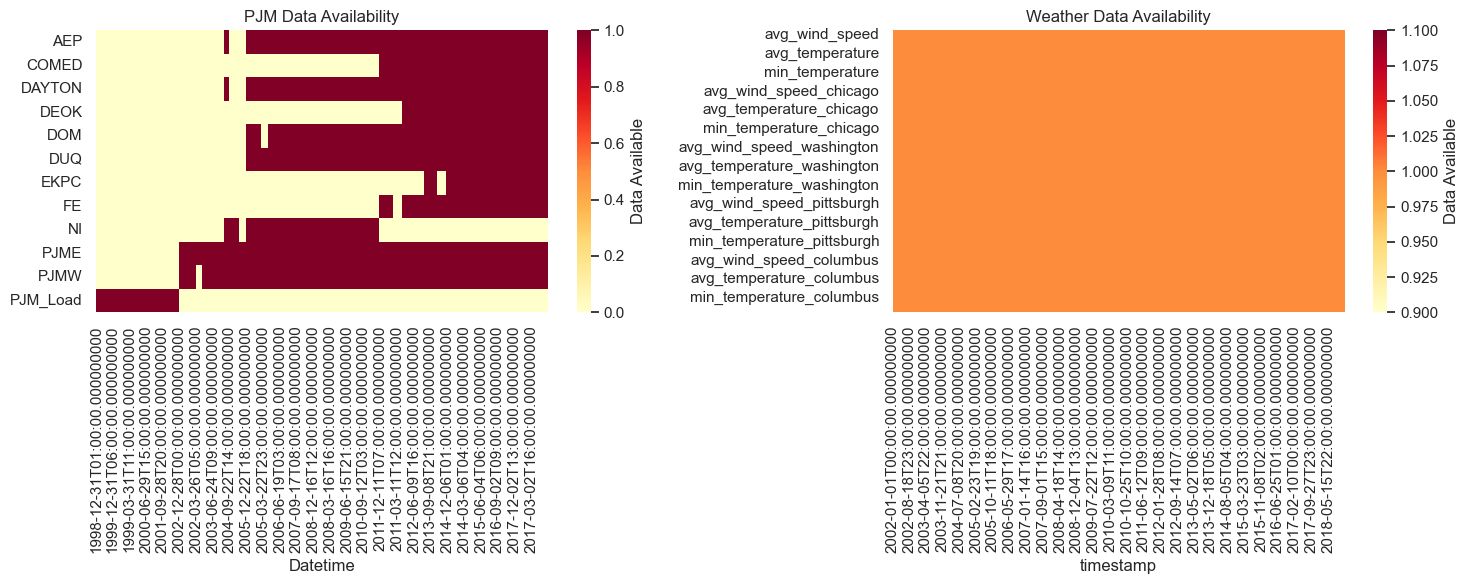


Data Coverage Analysis:
PJM unique dates: 7430
Weather unique dates: 6209
Overlapping dates: 6059

Key Variables Analysis:
Records with both PJME and PJMW: 143206

PJME Statistics:
count    143206.00
mean      32110.79
std        6488.18
min       14544.00
25%       27590.00
50%       31437.00
75%       35706.00
max       62009.00
Name: PJME, dtype: float64


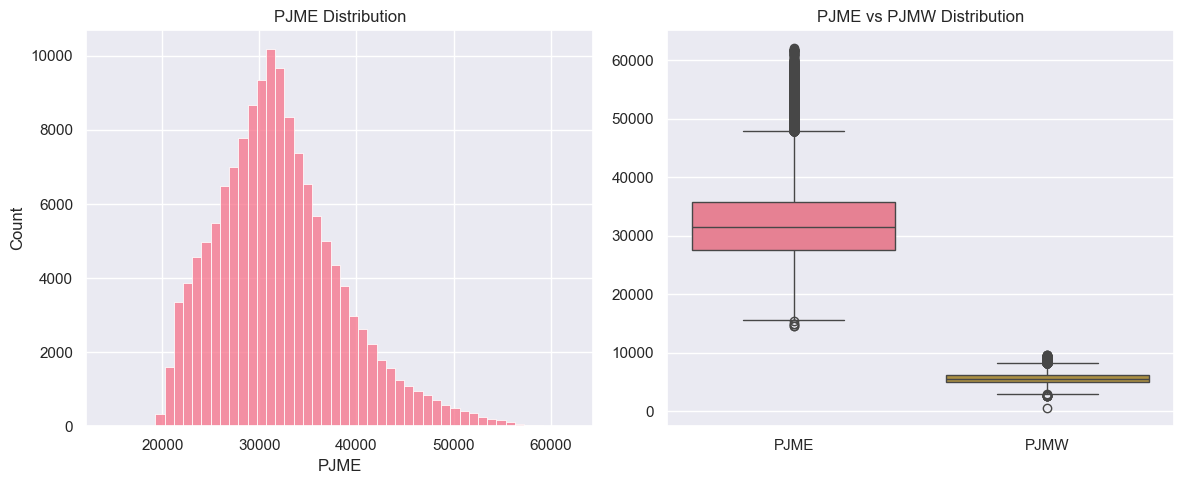

In [4]:
# First, let's analyze the data availability and time range

def analyze_data_completeness(df_pjm, df_weather):
    """
    Analyze completeness of both datasets
    """
    # Calculate missing percentages for PJM data
    pjm_missing = (df_pjm.isnull().sum() / len(df_pjm) * 100).round(2)
    
    # Time range analysis
    print("PJM Data Time Range:")
    print(f"Start: {df_pjm['Datetime'].min()}")
    print(f"End: {df_pjm['Datetime'].max()}")
    print(f"Total Hours: {len(df_pjm)}")
    
    print("\nMissing Data Percentages:")
    for col in df_pjm.columns:
        if col != 'Datetime':
            print(f"{col}: {pjm_missing[col]}%")
    
    # Visualize data availability
    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    plt.title('PJM Data Availability')
    sns.heatmap(df_pjm.set_index('Datetime').notna().T, 
                cmap='YlOrRd',
                cbar_kws={'label': 'Data Available'})
    
    plt.subplot(1, 2, 2)
    plt.title('Weather Data Availability')
    sns.heatmap(df_weather.set_index('timestamp').notna().T, 
                cmap='YlOrRd',
                cbar_kws={'label': 'Data Available'})
    plt.tight_layout()
    plt.show()
    
    # Analyze the overlap between PJM and weather data
    pjm_dates = set(df_pjm['Datetime'].dt.date)
    weather_dates = set(df_weather['timestamp'].dt.date)
    overlap_dates = pjm_dates.intersection(weather_dates)
    
    print("\nData Coverage Analysis:")
    print(f"PJM unique dates: {len(pjm_dates)}")
    print(f"Weather unique dates: {len(weather_dates)}")
    print(f"Overlapping dates: {len(overlap_dates)}")
    
    return pjm_missing

# Let's focus on our main variables of interest
def analyze_key_variables(df_pjm):
    """
    Analyze PJME and PJMW which have the most complete data
    """
    # Filter to where we have both PJME and PJMW
    complete_data = df_pjm[df_pjm['PJME'].notna() & df_pjm['PJMW'].notna()]
    
    print("\nKey Variables Analysis:")
    print(f"Records with both PJME and PJMW: {len(complete_data)}")
    print("\nPJME Statistics:")
    print(complete_data['PJME'].describe().round(2))
    
    # Plot PJME distribution
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.histplot(data=complete_data, x='PJME', bins=50)
    plt.title('PJME Distribution')
    
    plt.subplot(1, 2, 2)
    sns.boxplot(data=complete_data[['PJME', 'PJMW']])
    plt.title('PJME vs PJMW Distribution')
    plt.tight_layout()
    plt.show()
    
    return complete_data

# Execute the analysis
missing_data = analyze_data_completeness(df_pjm, df_weather)
complete_data = analyze_key_variables(df_pjm)

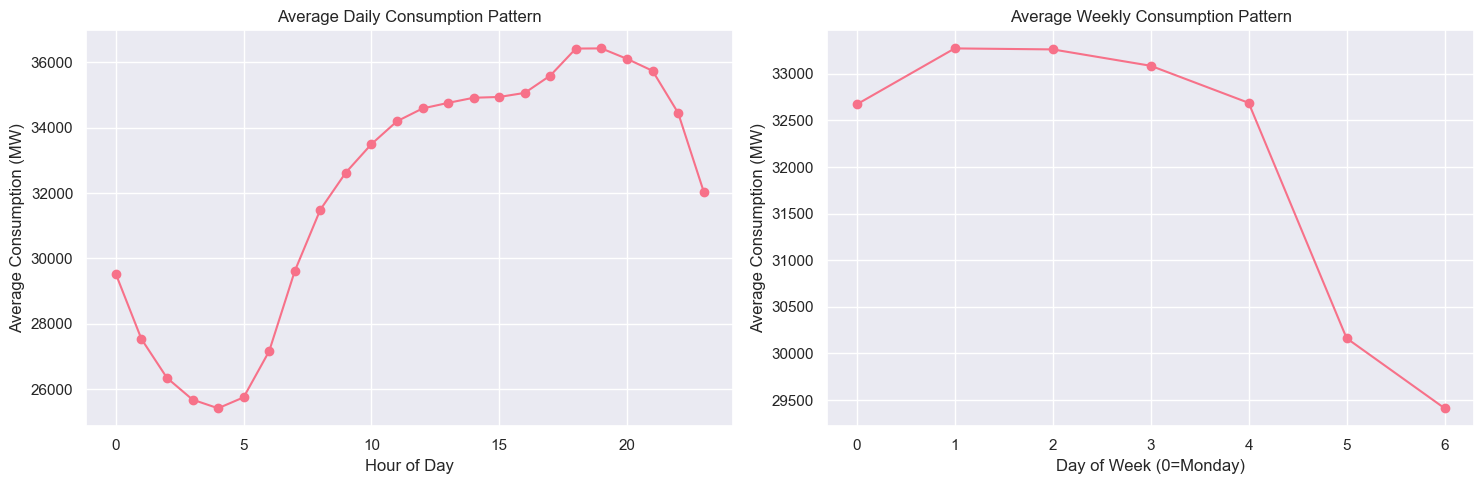

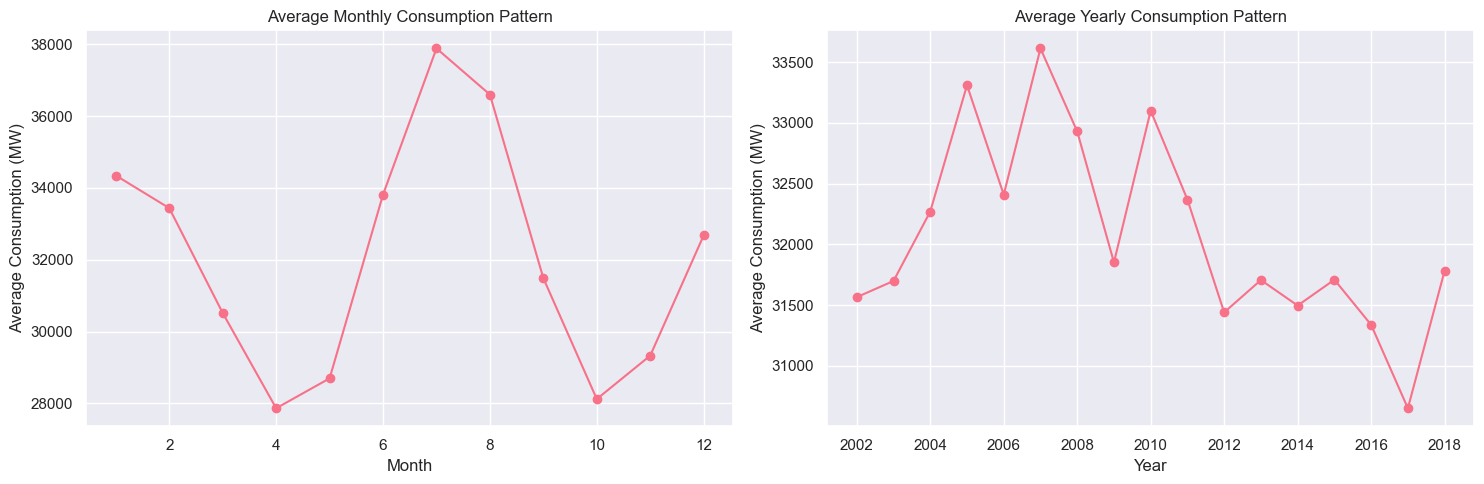

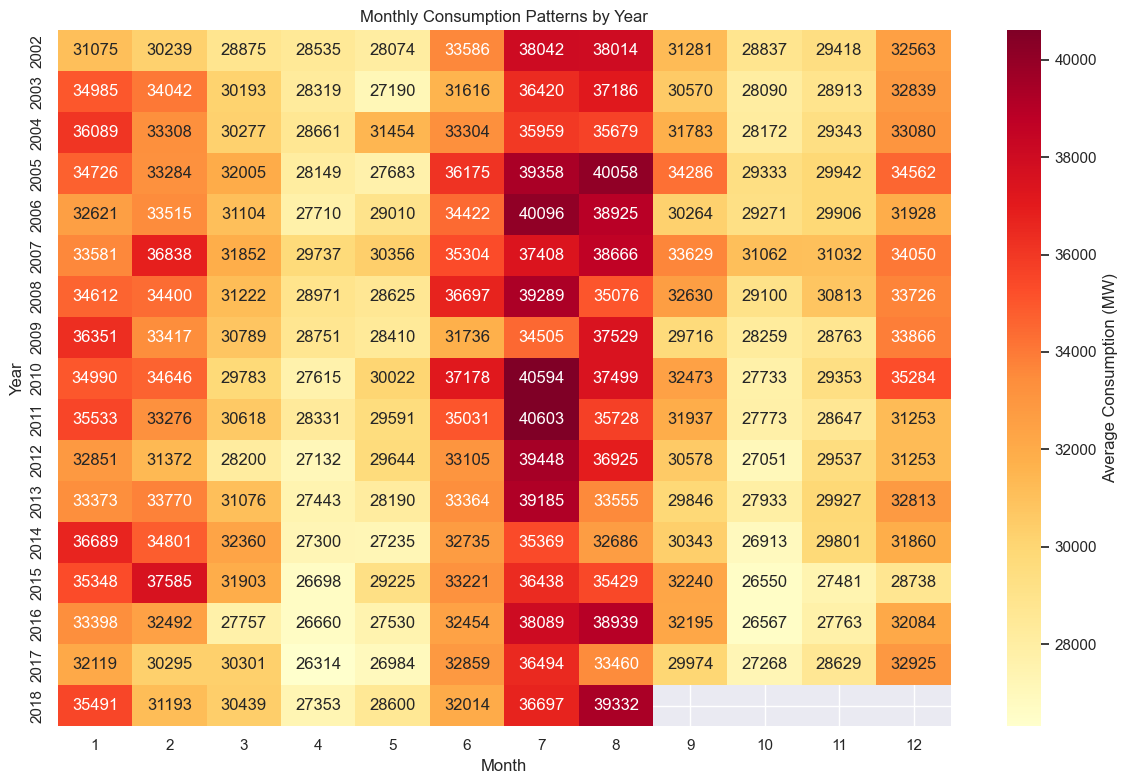

In [5]:
# Filter data to focus on complete period with both PJME and weather data
def analyze_temporal_patterns(df_pjm):
    """
    Analyze temporal patterns in energy consumption
    """
    # Filter to period from 2002 onwards and where PJME is available
    df = df_pjm[
        (df_pjm['Datetime'] >= '2002-01-01') & 
        (df_pjm['PJME'].notna())
    ].copy()
    
    # Add time components
    df['hour'] = df['Datetime'].dt.hour
    df['day'] = df['Datetime'].dt.day
    df['month'] = df['Datetime'].dt.month
    df['year'] = df['Datetime'].dt.year
    df['dayofweek'] = df['Datetime'].dt.dayofweek
    
    # 1. Daily Pattern
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    hourly_avg = df.groupby('hour')['PJME'].mean()
    plt.plot(hourly_avg.index, hourly_avg.values, marker='o')
    plt.title('Average Daily Consumption Pattern')
    plt.xlabel('Hour of Day')
    plt.ylabel('Average Consumption (MW)')
    plt.grid(True)
    
    # 2. Weekly Pattern
    plt.subplot(1, 2, 2)
    weekly_avg = df.groupby('dayofweek')['PJME'].mean()
    plt.plot(weekly_avg.index, weekly_avg.values, marker='o')
    plt.title('Average Weekly Consumption Pattern')
    plt.xlabel('Day of Week (0=Monday)')
    plt.ylabel('Average Consumption (MW)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # 3. Monthly and Yearly Patterns
    plt.figure(figsize=(15, 5))
    
    # Monthly pattern
    plt.subplot(1, 2, 1)
    monthly_avg = df.groupby('month')['PJME'].mean()
    plt.plot(monthly_avg.index, monthly_avg.values, marker='o')
    plt.title('Average Monthly Consumption Pattern')
    plt.xlabel('Month')
    plt.ylabel('Average Consumption (MW)')
    plt.grid(True)
    
    # Yearly pattern
    plt.subplot(1, 2, 2)
    yearly_avg = df.groupby('year')['PJME'].mean()
    plt.plot(yearly_avg.index, yearly_avg.values, marker='o')
    plt.title('Average Yearly Consumption Pattern')
    plt.xlabel('Year')
    plt.ylabel('Average Consumption (MW)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # 4. Monthly patterns by year (heatmap)
    monthly_by_year = df.pivot_table(
        index='year',
        columns='month',
        values='PJME',
        aggfunc='mean'
    )
    
    plt.figure(figsize=(12, 8))
    sns.heatmap(monthly_by_year, 
                cmap='YlOrRd',
                annot=True,
                fmt='.0f',
                cbar_kws={'label': 'Average Consumption (MW)'})
    plt.title('Monthly Consumption Patterns by Year')
    plt.xlabel('Month')
    plt.ylabel('Year')
    plt.tight_layout()
    plt.show()
    
    return df

# Execute the analysis
filtered_data = analyze_temporal_patterns(df_pjm)

In [9]:
def clean_weather_data(df_weather):
    """
    Clean and validate weather data, ensuring temperatures are in reasonable ranges
    """
    df = df_weather.copy()
    
    # Function to identify unreasonable temperatures (in Celsius)
    def is_valid_temp(temp):
        return -50 <= temp <= 50  # reasonable range for these cities
    
    # Print some sample data before cleaning
    print("Sample of original temperature data:")
    for city in ['chicago', 'washington', 'pittsburgh', 'columbus']:
        print(f"\n{city.capitalize()} first 5 temperatures:")
        print(df[f'temperature_{city}'].head())
    
    # Check value ranges
    for city in ['chicago', 'washington', 'pittsburgh', 'columbus']:
        temp_col = f'temperature_{city}'
        print(f"\n{city.capitalize()} temperature range:")
        print(f"Min: {df[temp_col].min():.2f}°C")
        print(f"Max: {df[temp_col].max():.2f}°C")
        print(f"Mean: {df[temp_col].mean():.2f}°C")
        
        # Count invalid temperatures
        invalid_temps = df[~df[temp_col].apply(is_valid_temp)].shape[0]
        print(f"Invalid temperatures: {invalid_temps} records")
    
    # Identify potential scaling issues
    for city in ['chicago', 'washington', 'pittsburgh', 'columbus']:
        temp_col = f'temperature_{city}'
        if df[temp_col].abs().max() > 100:  # If we see temperatures >100°C
            print(f"\nPossible scaling issue detected in {city} temperatures")
            
    return df

# Run the data validation
cleaned_weather = clean_weather_data(df_weather)

Sample of original temperature data:

Chicago first 5 temperatures:
0   -29.875000
1   -29.403586
2   -28.149496
3   -26.104037
4   -23.338317
Name: temperature_chicago, dtype: float64

Washington first 5 temperatures:
0   -13.400000
1   -13.703793
2   -13.333862
3   -12.285536
4   -10.618494
Name: temperature_washington, dtype: float64

Pittsburgh first 5 temperatures:
0   -18.750000
1   -18.288024
2   -17.454815
3   -16.307077
4   -14.916707
Name: temperature_pittsburgh, dtype: float64

Columbus first 5 temperatures:
0   -12.550000
1   -12.263817
2   -11.670002
3   -10.799091
4    -9.701141
Name: temperature_columbus, dtype: float64

Chicago temperature range:
Min: -65.25°C
Max: 5398.28°C
Mean: 1562.05°C
Invalid temperatures: 87950 records

Washington temperature range:
Min: -603.49°C
Max: 3924.16°C
Mean: 786.17°C
Invalid temperatures: 84201 records

Pittsburgh temperature range:
Min: -36.97°C
Max: 5458.65°C
Mean: 1545.12°C
Invalid temperatures: 67122 records

Columbus temperature ra


Chicago first unreasonable temperature:
Date: 2002-03-03 22:00:00
Temperature: -52.56°C

Surrounding values:
               timestamp  temperature_chicago
1484 2002-03-03 20:00:00           -46.435903
1485 2002-03-03 21:00:00           -49.969873
1486 2002-03-03 22:00:00           -52.555842
1487 2002-03-03 23:00:00           -53.984258
1488 2002-03-04 00:00:00           -54.125000

Washington first unreasonable temperature:
Date: 2002-01-29 12:00:00
Temperature: 50.06°C

Surrounding values:
              timestamp  temperature_washington
682 2002-01-29 10:00:00               46.775004
683 2002-01-29 11:00:00               48.925346
684 2002-01-29 12:00:00               50.058047
685 2002-01-29 13:00:00               50.110391
686 2002-01-29 14:00:00               49.095983

Pittsburgh first unreasonable temperature:
Date: 2002-07-02 11:00:00
Temperature: 50.18°C

Surrounding values:
               timestamp  temperature_pittsburgh
4377 2002-07-02 09:00:00               47.761539
4378

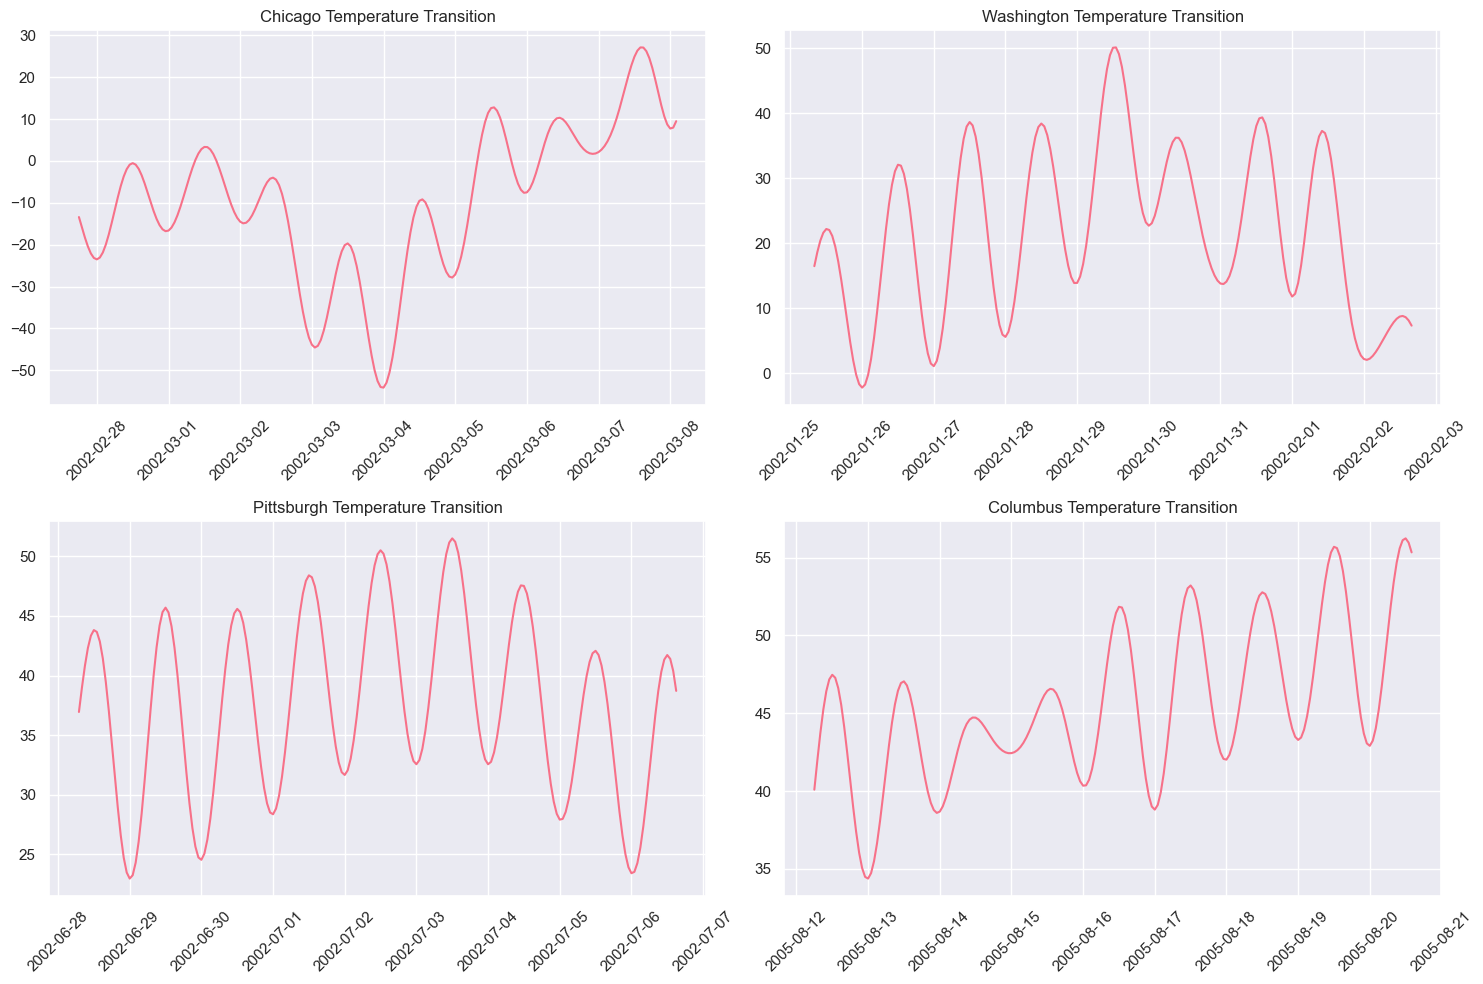

In [10]:
def diagnose_temperature_break(df_weather):
    """
    Identify where temperature values start becoming unreasonable
    """
    df = df_weather.copy()
    
    def is_reasonable(temp):
        return -50 <= temp <= 50
    
    # Add a flag for reasonable temperatures
    for city in ['chicago', 'washington', 'pittsburgh', 'columbus']:
        temp_col = f'temperature_{city}'
        df[f'{city}_reasonable'] = df[temp_col].apply(is_reasonable)
    
    # Find first unreasonable value for each city
    for city in ['chicago', 'washington', 'pittsburgh', 'columbus']:
        temp_col = f'temperature_{city}'
        reasonable_col = f'{city}_reasonable'
        
        # Find first unreasonable value
        first_unreasonable = df[~df[reasonable_col]].iloc[0]
        print(f"\n{city.capitalize()} first unreasonable temperature:")
        print(f"Date: {first_unreasonable['timestamp']}")
        print(f"Temperature: {first_unreasonable[temp_col]:.2f}°C")
        
        # Show surrounding values
        idx = df[~df[reasonable_col]].index[0]
        print("\nSurrounding values:")
        print(df.loc[max(0, idx-2):min(len(df)-1, idx+2), 
                    ['timestamp', temp_col]])
    
    # Plot temperature transition around the break point
    plt.figure(figsize=(15, 10))
    for i, city in enumerate(['chicago', 'washington', 'pittsburgh', 'columbus']):
        temp_col = f'temperature_{city}'
        plt.subplot(2, 2, i+1)
        
        # Get index of first unreasonable value
        break_idx = df[~df[f'{city}_reasonable']].index[0]
        
        # Plot temperatures around the break point
        window = 100  # number of points before and after break
        plot_data = df.loc[max(0, break_idx-window):min(len(df)-1, break_idx+window)]
        plt.plot(plot_data['timestamp'], plot_data[temp_col])
        plt.title(f'{city.capitalize()} Temperature Transition')
        plt.xticks(rotation=45)
        plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    return df

# Run the diagnosis
diagnosed_weather = diagnose_temperature_break(df_weather)

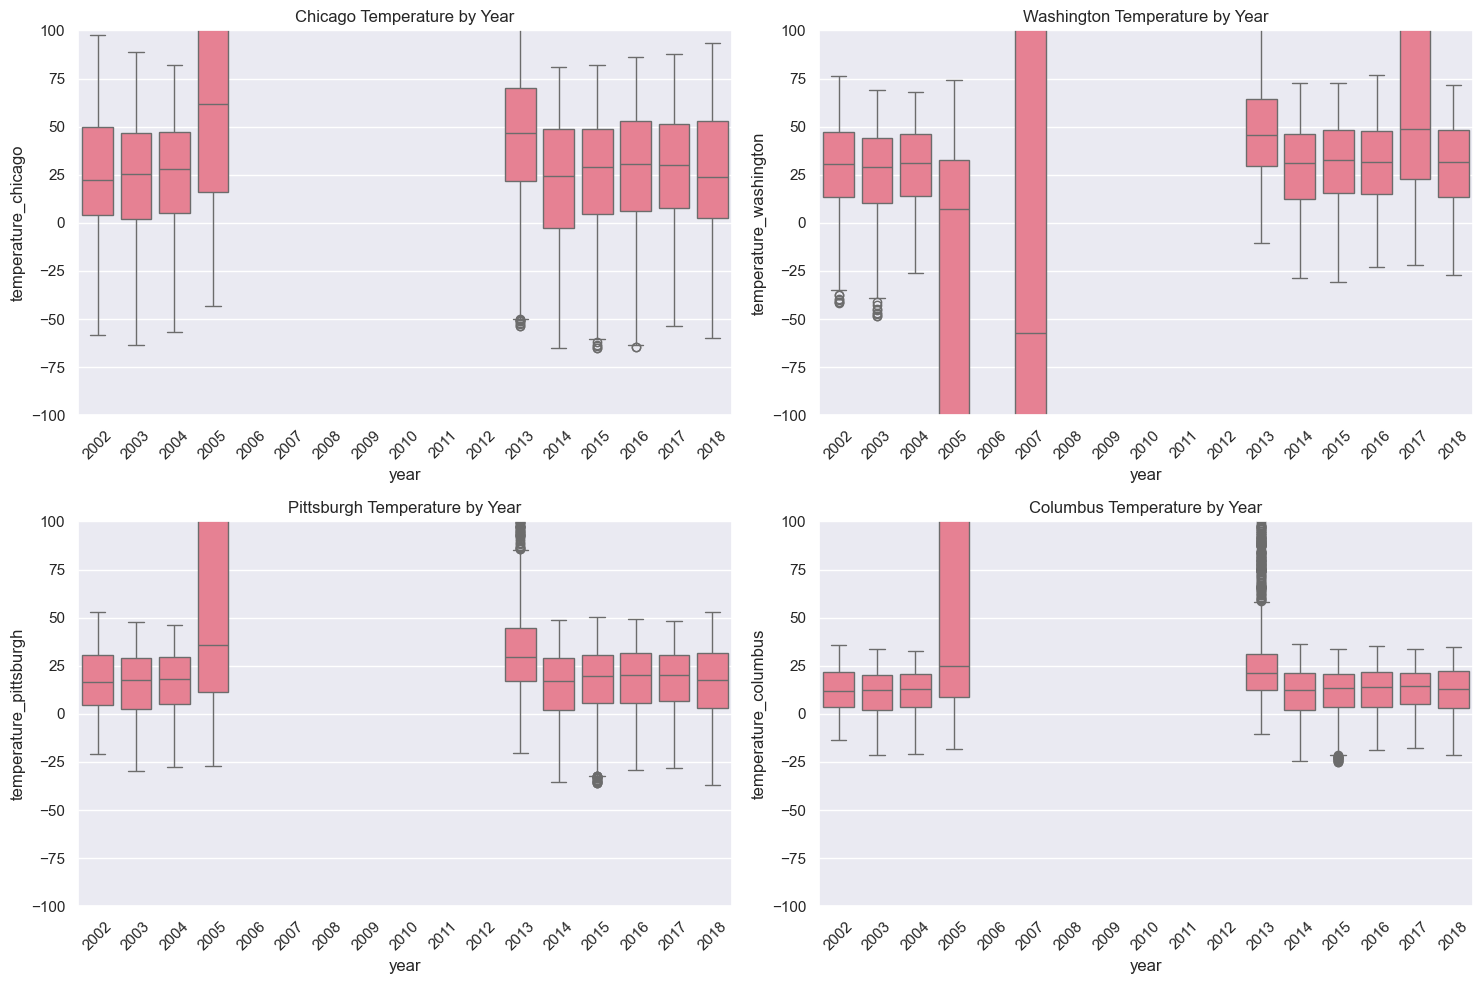


Chicago yearly statistics:
         mean      min      max
year                           
2002    26.31   -58.38    97.44
2003    23.91   -63.48    88.79
2004    25.24   -56.89    81.77
2005   365.58   -43.16  1556.70
2006  2900.07  1537.89  4020.83
2007  4697.87  4004.19  5197.68
2008  5330.16  5171.70  5398.28
2009  5042.63  4641.34  5330.78
2010  4084.71  3426.25  4660.98
2011  2704.20  1924.87  3456.87
2012  1146.38   360.81  1941.81
2013    71.47   -53.42   380.53
2014    22.05   -65.23    80.90
2015    25.62   -65.25    82.23
2016    28.47   -64.75    85.98
2017    28.74   -53.55    87.88
2018    26.56   -59.73    93.44

Chicago temperature range distribution:
  -inf°C to    -50°C:    247 values (0.2%)
   -50°C to      0°C:  16238 values (10.9%)
     0°C to     25°C:  22343 values (15.0%)
    25°C to     50°C:  22462 values (15.1%)
    50°C to    100°C:  21120 values (14.2%)
   100°C to    inf°C:  66583 values (44.7%)

Washington yearly statistics:
         mean      min      m

In [11]:
def analyze_temperature_distribution(df_weather):
    """
    Analyze the distribution of temperatures to identify patterns and anomalies
    """
    df = df_weather.copy()
    
    # Add year column for temporal analysis
    df['year'] = df['timestamp'].dt.year
    
    # Create subplots for each city
    plt.figure(figsize=(15, 10))
    
    for i, city in enumerate(['chicago', 'washington', 'pittsburgh', 'columbus']):
        temp_col = f'temperature_{city}'
        
        plt.subplot(2, 2, i+1)
        
        # Create yearly boxplots to see if the distribution changes
        sns.boxplot(data=df, x='year', y=temp_col)
        plt.title(f'{city.capitalize()} Temperature by Year')
        plt.xticks(rotation=45)
        plt.ylim(-100, 100)  # Focus on reasonable range first
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics by year
    for city in ['chicago', 'washington', 'pittsburgh', 'columbus']:
        temp_col = f'temperature_{city}'
        print(f"\n{city.capitalize()} yearly statistics:")
        yearly_stats = df.groupby('year')[temp_col].agg(['mean', 'min', 'max'])
        print(yearly_stats.round(2))
        
        # Count values in different ranges
        ranges = [
            (-float('inf'), -50),
            (-50, 0),
            (0, 25),
            (25, 50),
            (50, 100),
            (100, float('inf'))
        ]
        
        print(f"\n{city.capitalize()} temperature range distribution:")
        for start, end in ranges:
            count = df[(df[temp_col] > start) & (df[temp_col] <= end)].shape[0]
            pct = count / len(df) * 100
            print(f"{start:>6.0f}°C to {end:>6.0f}°C: {count:>6d} values ({pct:.1f}%)")

# Run the distribution analysis
analyze_temperature_distribution(df_weather)

Cleaned Data Summary:
Original records: 148993
Cleaned records: 70105

Temperature Statistics After Cleaning:

Chicago:
count    70105.00
mean        25.86
std         29.02
min        -65.25
25%          3.90
50%         26.70
75%         49.77
max         97.44
Name: temperature_chicago, dtype: float64

Washington:
count    70105.00
mean        36.69
std         38.00
min        -48.52
25%         14.36
50%         32.74
75%         48.69
max        234.20
Name: temperature_washington, dtype: float64

Pittsburgh:
count    70105.00
mean        16.95
std         16.39
min        -36.97
25%          4.22
50%         18.47
75%         30.25
max         53.10
Name: temperature_pittsburgh, dtype: float64

Columbus:
count    70105.00
mean        12.11
std         11.11
min        -25.25
25%          3.41
50%         13.15
75%         21.16
max         36.10
Name: temperature_columbus, dtype: float64


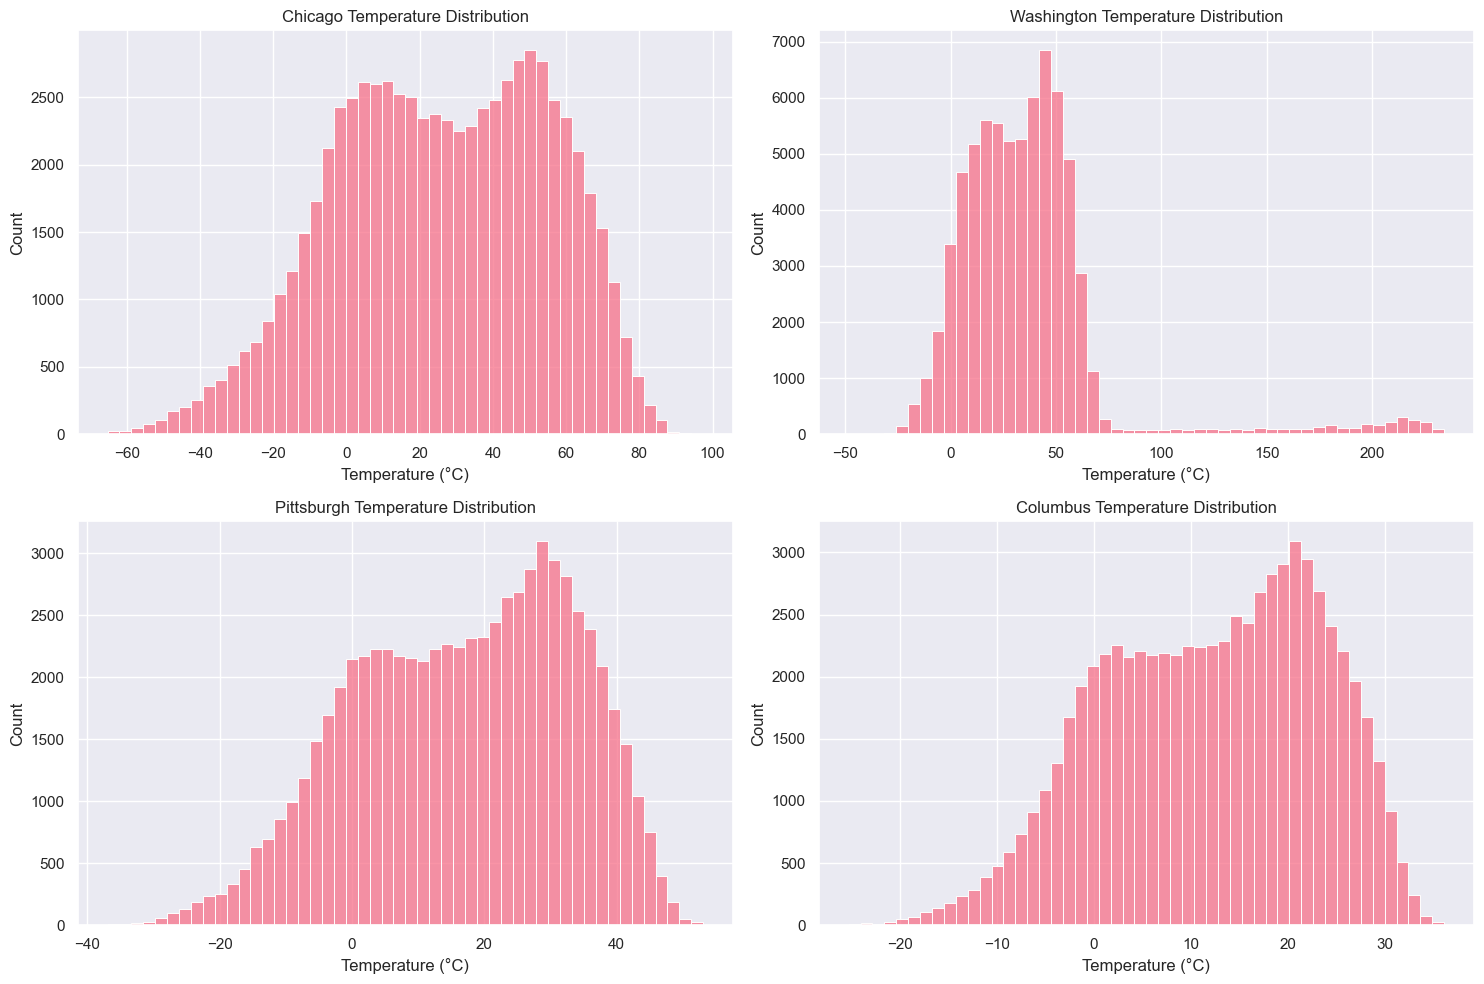

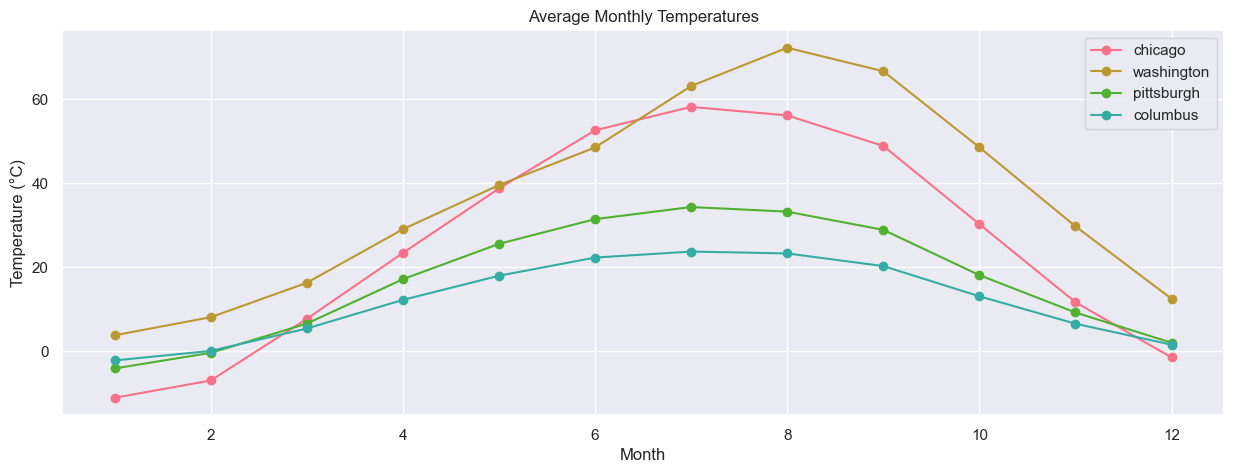

In [12]:
def clean_weather_data(df_weather):
    """
    Clean weather data by removing the corrupted period
    """
    df = df_weather.copy()
    
    # Add year column
    df['year'] = df['timestamp'].dt.year
    
    # Create mask for valid periods
    valid_period = ((df['year'] < 2005) | (df['year'] >= 2014))
    df_clean = df[valid_period].copy()
    
    # Verify cleaned data
    cities = ['chicago', 'washington', 'pittsburgh', 'columbus']
    
    print("Cleaned Data Summary:")
    print(f"Original records: {len(df)}")
    print(f"Cleaned records: {len(df_clean)}")
    print("\nTemperature Statistics After Cleaning:")
    
    for city in cities:
        temp_col = f'temperature_{city}'
        stats = df_clean[temp_col].describe()
        print(f"\n{city.capitalize()}:")
        print(stats.round(2))
    
    # Plot cleaned temperature distributions
    plt.figure(figsize=(15, 10))
    for i, city in enumerate(cities):
        temp_col = f'temperature_{city}'
        
        plt.subplot(2, 2, i+1)
        sns.histplot(data=df_clean, x=temp_col, bins=50)
        plt.title(f'{city.capitalize()} Temperature Distribution')
        plt.xlabel('Temperature (°C)')
    
    plt.tight_layout()
    plt.show()
    
    # Monthly temperature patterns
    df_clean['month'] = df_clean['timestamp'].dt.month
    
    plt.figure(figsize=(15, 5))
    for city in cities:
        temp_col = f'temperature_{city}'
        monthly_avg = df_clean.groupby('month')[temp_col].mean()
        plt.plot(monthly_avg.index, monthly_avg.values, marker='o', label=city)
    
    plt.title('Average Monthly Temperatures')
    plt.xlabel('Month')
    plt.ylabel('Temperature (°C)')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return df_clean

# Clean the data
cleaned_weather = clean_weather_data(df_weather)

Records removed by city:
Chicago: 26078 records removed
Washington: 5948 records removed
Pittsburgh: 4 records removed
Columbus: 0 records removed

Cleaned Data Summary:
Final record count: 38075

Chicago Temperature Statistics:
count    38075.00
mean         8.99
std         17.44
min        -30.00
25%         -3.69
50%          9.03
75%         22.67
max         41.98
Name: temperature_chicago, dtype: float64

Washington Temperature Statistics:
count    38075.00
mean        17.68
std         13.12
min        -26.00
25%          7.88
50%         18.07
75%         28.19
max         41.00
Name: temperature_washington, dtype: float64

Pittsburgh Temperature Statistics:
count    38075.00
mean         7.35
std         10.86
min        -27.90
25%         -0.58
50%          7.56
75%         15.89
max         37.65
Name: temperature_pittsburgh, dtype: float64

Columbus Temperature Statistics:
count    38075.00
mean         5.64
std          7.26
min        -20.10
25%          0.20
50%        

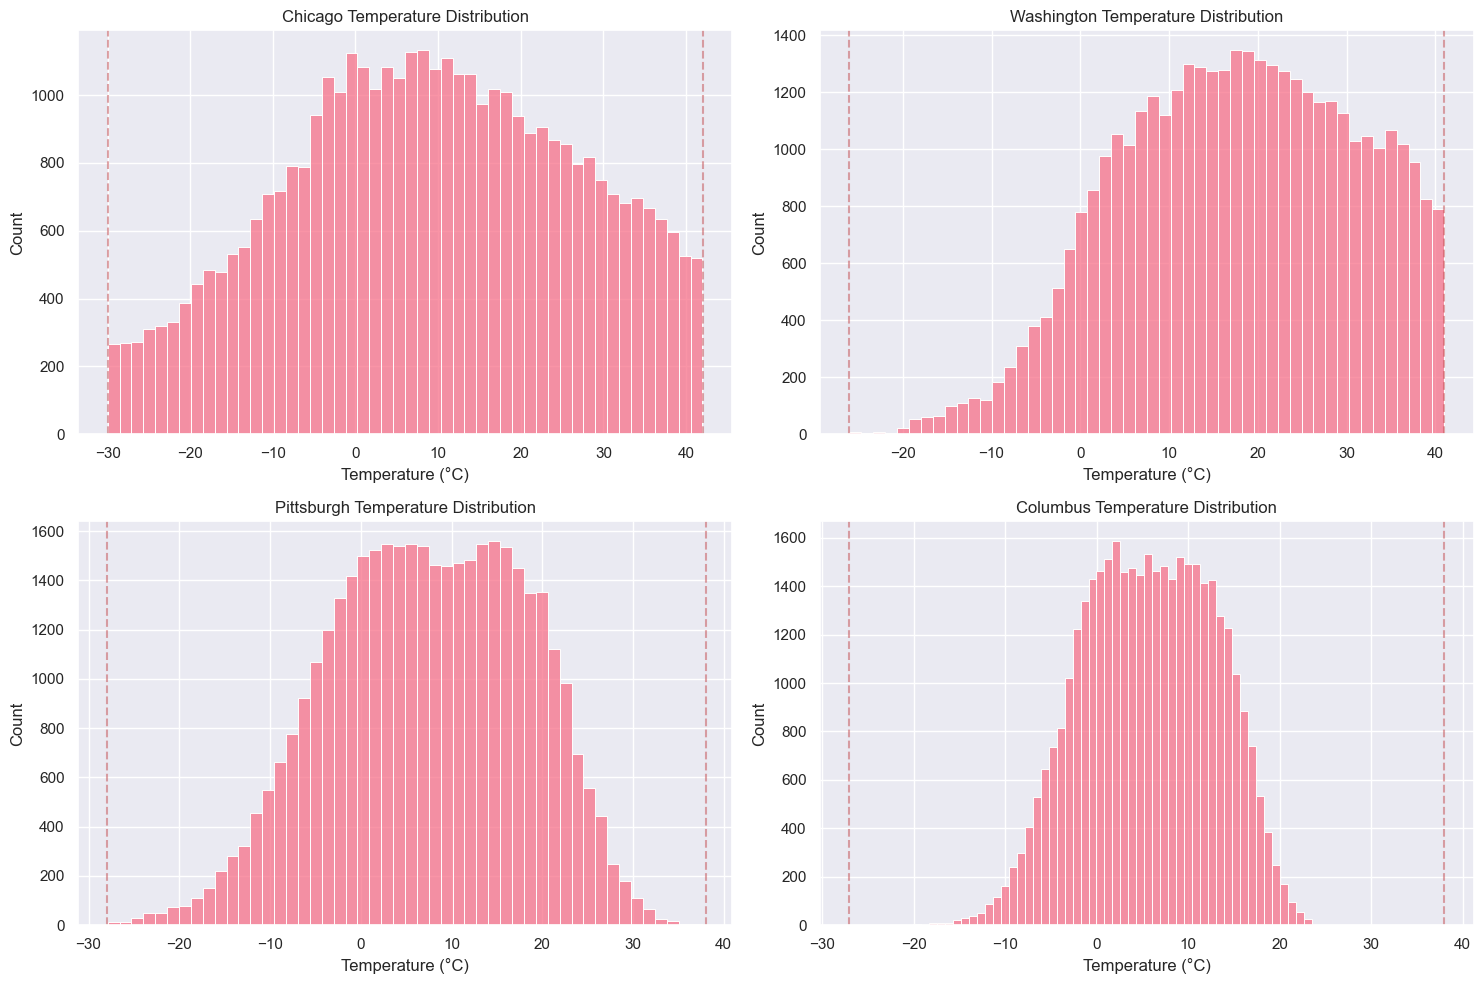

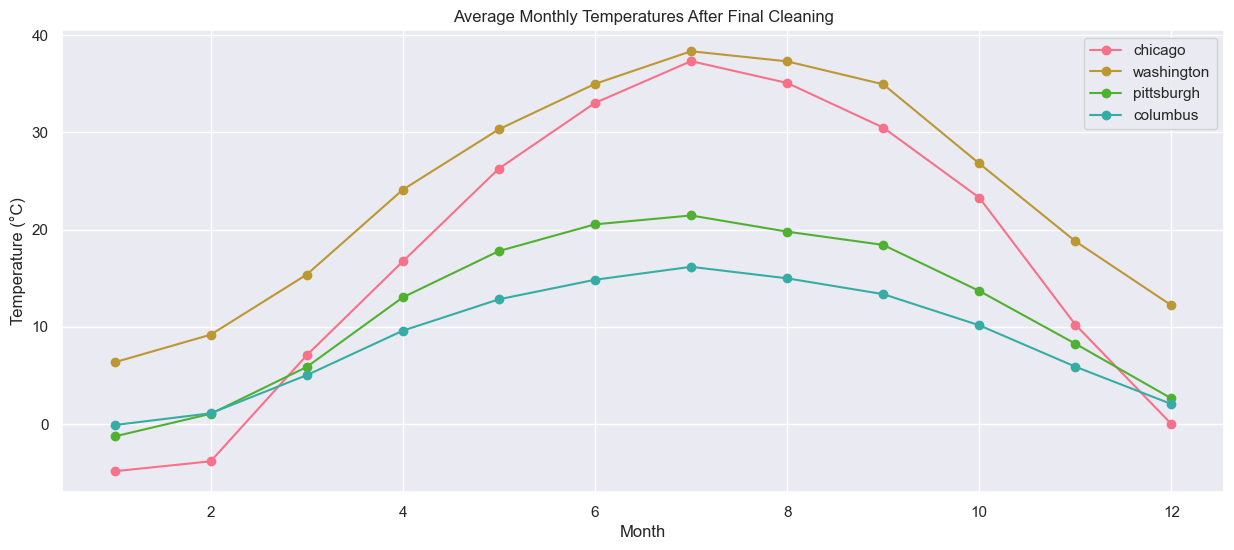

In [13]:
def apply_final_cleaning(df_weather):
    """
    Apply final cleaning with reasonable temperature ranges for each city
    Based on historical records and typical climate patterns
    """
    df = df_weather.copy()
    
    # Define reasonable temperature ranges for each city
    city_limits = {
        'chicago': {
            'min': -30,  # Chicago record low is around -33°C
            'max': 42    # Chicago record high is around 41°C
        },
        'washington': {
            'min': -26,  # DC record low is around -26°C
            'max': 41    # DC record high is around 40°C
        },
        'pittsburgh': {
            'min': -28,  # Pittsburgh record low is around -27°C
            'max': 38    # Pittsburgh record high is around 37°C
        },
        'columbus': {
            'min': -27,  # Columbus record low is around -26°C
            'max': 38    # Columbus record high is around 37°C
        }
    }
    
    # Filter data within reasonable ranges
    print("Records removed by city:")
    for city, limits in city_limits.items():
        temp_col = f'temperature_{city}'
        original_count = len(df)
        df = df[
            (df[temp_col] >= limits['min']) & 
            (df[temp_col] <= limits['max'])
        ]
        removed = original_count - len(df)
        print(f"{city.capitalize()}: {removed} records removed")
    
    print("\nCleaned Data Summary:")
    print(f"Final record count: {len(df)}")
    
    # Print statistics for cleaned data
    for city in city_limits.keys():
        temp_col = f'temperature_{city}'
        print(f"\n{city.capitalize()} Temperature Statistics:")
        print(df[temp_col].describe().round(2))
        
    # Visualize final temperature distributions
    plt.figure(figsize=(15, 10))
    for i, city in enumerate(city_limits.keys()):
        temp_col = f'temperature_{city}'
        
        plt.subplot(2, 2, i+1)
        sns.histplot(data=df, x=temp_col, bins=50)
        plt.title(f'{city.capitalize()} Temperature Distribution')
        plt.xlabel('Temperature (°C)')
        plt.axvline(city_limits[city]['min'], color='r', linestyle='--', alpha=0.5)
        plt.axvline(city_limits[city]['max'], color='r', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()
    
    # Show seasonal patterns
    df['month'] = df['timestamp'].dt.month
    plt.figure(figsize=(15, 6))
    
    # Monthly averages
    for city in city_limits.keys():
        temp_col = f'temperature_{city}'
        monthly_avg = df.groupby('month')[temp_col].mean()
        plt.plot(monthly_avg.index, monthly_avg.values, marker='o', label=city)
    
    plt.title('Average Monthly Temperatures After Final Cleaning')
    plt.xlabel('Month')
    plt.ylabel('Temperature (°C)')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return df

# Apply final cleaning
final_clean_weather = apply_final_cleaning(cleaned_weather)

In [14]:
def combined_analysis(df_pjm, df_weather):
    """
    Combine PJM energy data with NOAA weather data
    """
    # Ensure datetime columns are named consistently
    df_pjm.rename(columns={"Datetime": "timestamp"}, inplace=True)
    
    # Merge the datasets
    df_combined = pd.merge(df_pjm, df_weather, on='timestamp', how='inner')
    
    # Display information about the combined dataset
    print("Combined Dataset Shape:", df_combined.shape)
    print("\nCombined Dataset Info:")
    print(df_combined.info())
    
    # Check for missing data
    missing_data_combined = df_combined.isnull().sum().sort_values(ascending=False)
    print("\nMissing Data in Combined Dataset:")
    print(missing_data_combined[missing_data_combined > 0])
    
    return df_combined

# Execute the combination
df_combined = combined_analysis(df_pjm, final_clean_weather)


Combined Dataset Shape: (36000, 45)

Combined Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36000 entries, 0 to 35999
Data columns (total 45 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   timestamp                   36000 non-null  datetime64[ns]
 1   AEP                         22437 non-null  float64       
 2   COMED                       20477 non-null  float64       
 3   DAYTON                      22437 non-null  float64       
 4   DEOK                        20477 non-null  float64       
 5   DOM                         20477 non-null  float64       
 6   DUQ                         20477 non-null  float64       
 7   EKPC                        20477 non-null  float64       
 8   FE                          20477 non-null  float64       
 9   NI                          2543 non-null   float64       
 10  PJME                        35999 non-null  float64       

In [15]:
def clean_combined_data(df_combined):
    """
    Drop or impute missing columns and prepare the dataset for analysis.
    """
    # Drop columns with too much missing data
    cols_to_drop = ['PJM_Load', 'NI']  # Highly incomplete
    df_cleaned = df_combined.drop(columns=cols_to_drop, errors='ignore')
    
    # Impute missing energy consumption with forward fill (time-series data)
    df_cleaned['PJME'].fillna(method='ffill', inplace=True)
    df_cleaned['PJMW'].fillna(method='ffill', inplace=True)
    
    # Drop rows with remaining nulls
    df_cleaned.dropna(inplace=True)
    
    print("Cleaned Dataset Shape:", df_cleaned.shape)
    print("Remaining Missing Data:\n", df_cleaned.isnull().sum().sort_values(ascending=False))
    return df_cleaned

# Clean the data
df_cleaned = clean_combined_data(df_combined)


Cleaned Dataset Shape: (20477, 43)
Remaining Missing Data:
 timestamp                     0
max_temperature_pittsburgh    0
precipitation_washington      0
avg_temperature_washington    0
max_temperature_washington    0
min_temperature_washington    0
temperature_washington        0
avg_wind_speed_pittsburgh     0
precipitation_pittsburgh      0
avg_temperature_pittsburgh    0
min_temperature_pittsburgh    0
temperature_chicago           0
temperature_pittsburgh        0
avg_wind_speed_columbus       0
precipitation_columbus        0
avg_temperature_columbus      0
max_temperature_columbus      0
min_temperature_columbus      0
temperature_columbus          0
year                          0
avg_wind_speed_washington     0
min_temperature_chicago       0
AEP                           0
PJMW                          0
COMED                         0
DAYTON                        0
DEOK                          0
DOM                           0
DUQ                           0
EKPC        


Detailed Correlations:

PJME Correlations:
- PJMW: 0.955 (strong positive correlation)
- avg_wind_speed_chicago: 0.077 (weak positive correlation)
- avg_wind_speed_columbus: 0.051 (weak positive correlation)
- avg_wind_speed_pittsburgh: 0.028 (weak positive correlation)
- avg_wind_speed_washington: 0.016 (weak positive correlation)
- precipitation_washington: -0.016 (weak negative correlation)
- precipitation_pittsburgh: -0.031 (weak negative correlation)
- precipitation_columbus: -0.051 (weak negative correlation)
- precipitation_chicago: -0.083 (weak negative correlation)
- temperature_chicago: -0.452 (moderate negative correlation)
- temperature_columbus: -0.467 (moderate negative correlation)
- temperature_pittsburgh: -0.477 (moderate negative correlation)
- temperature_washington: -0.504 (moderate negative correlation)

PJMW Correlations:
- PJME: 0.955 (strong positive correlation)
- avg_wind_speed_chicago: 0.075 (weak positive correlation)
- avg_wind_speed_columbus: 0.056 (weak 

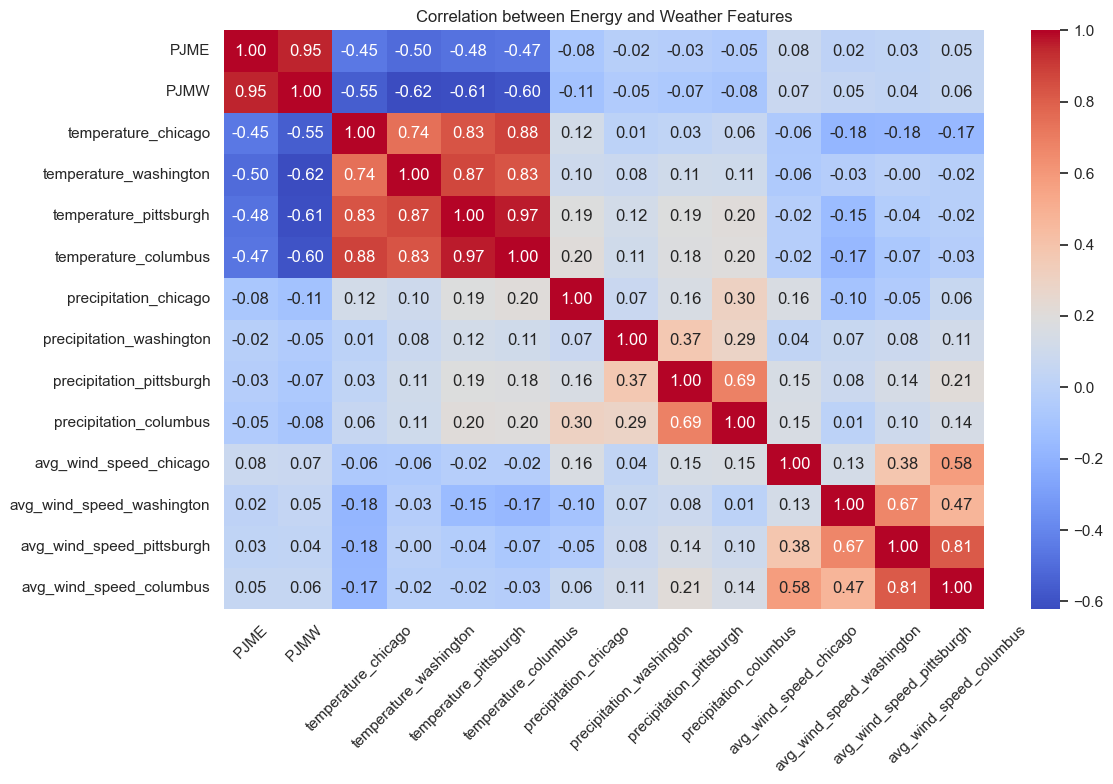

In [21]:
def correlation_analysis(df_cleaned):
    """
    Analyze correlation between weather features and energy consumption.
    """
    # Select columns of interest
    energy_cols = ['PJME', 'PJMW']
    weather_cols = [
        'temperature_chicago', 'temperature_washington', 
        'temperature_pittsburgh', 'temperature_columbus',
        'precipitation_chicago', 'precipitation_washington',
        'precipitation_pittsburgh', 'precipitation_columbus',
        'avg_wind_speed_chicago', 'avg_wind_speed_washington',
        'avg_wind_speed_pittsburgh', 'avg_wind_speed_columbus'
    ]
    
    # Compute correlation matrix
    correlation_matrix = df_cleaned[energy_cols + weather_cols].corr()
    
    
    print("\nDetailed Correlations:")
    # Analyze correlations for each energy region
    for energy_col in energy_cols:
        print(f"\n{energy_col} Correlations:")
        correlations = correlation_matrix[energy_col].sort_values(ascending=False)
        
        # Skip self-correlation
        correlations = correlations[correlations.index != energy_col]
        
        for feature, corr in correlations.items():
            strength = "strong" if abs(corr) > 0.7 else "moderate" if abs(corr) > 0.4 else "weak"
            direction = "positive" if corr > 0 else "negative"
            print(f"- {feature}: {corr:.3f} ({strength} {direction} correlation)")
    
    # Visualize the correlation matrix
    plt.figure(figsize=(12, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation between Energy and Weather Features")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


# Execute the analysis
correlation_analysis(df_cleaned)